# __Induced Dark Matter Bar in Galaxy Simulation__
## Noah Herrero
___
## <font color='purple'> __Part 1__</font>
***Finding a Bar***

In [1]:
import pynbody #Needed to load large data files, and for data analysis
import matplotlib.pyplot as plt #General Plotting
import numpy as np #Array analysis
from tqdm import tqdm #Convenience in checking how long for loops would take
%matplotlib inline

To start the analysis I need to actually be able to read my data, so I create an array that contains all of them below

In [2]:
i = 0
List = []
while i <= 445:
	number = i
	boss="{:04d}".format(number)
	List.append(boss+'.txt')
	i +=1

#Define important constants for later use
centre = (0,0,0)
nbins = 100

In [67]:
#Loading text now;
#Note now this can be easily put into a for loop for later use

s=pynbody.load(List[445], header='id mass x y z vx vy vz eps')

#Taking only the dark matter
s_dm = s[s['mass']==3.60000001E-07]

#Isolating only the inner radius of 3kpc
sph = s_dm[pynbody.filt.Sphere(3, centre)]

To clarify why only the inner 3kpc is being useed, we know that the bar ends at 5 kpc, so to get the best data we can look within that region, and exclude any potential area where the bar is too weak

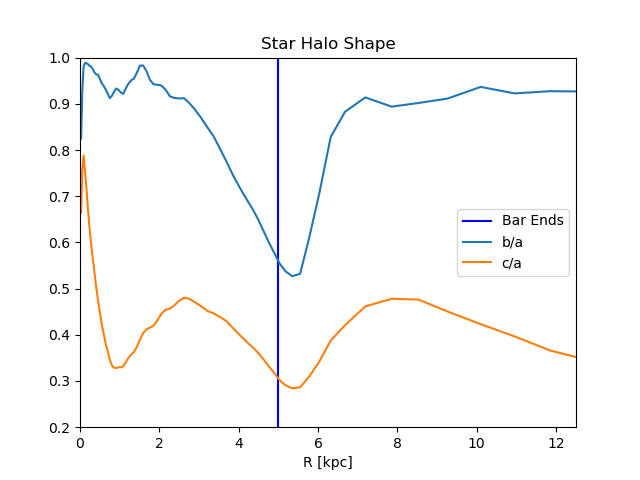

/data1/herrernj/run1-count/jupyter-env/lib/python3.10/site-packages/pynbody/plot/generic.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  phi_hist[i, :] = phi_hist[i,:] + p['fourier']['c'][m, i]*np.exp(1j*m*phi)
/data1/herrernj/run1-count/jupyter-env/lib/python3.10/site-packages/pynbody/plot/generic.py:565: UserWarning: The following kwargs were not used by contour: 'radius'
  plt.contour(xx, yy, phi_inv, levels, **kwargs)


(-3.0, 3.0)

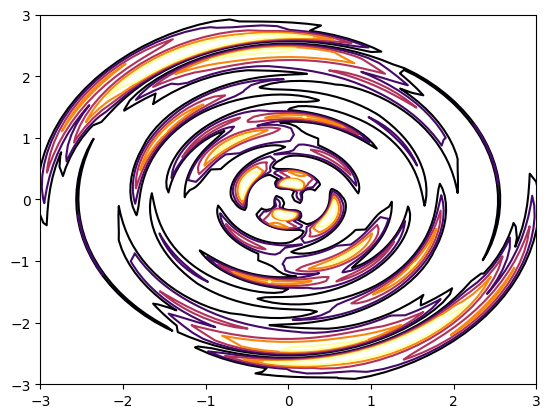

In [68]:
#Creating Fourier Map using Pynbody
x, y, z = pynbody.plot.generic.fourier_map(sph,mmin = 2, mmax =3, levels=[0.001,0.005,0.01,0.015,0.02], nbins=nbins, nmin=1000, return_array = True, radius = 3, cmap = 'inferno')
plt.xlim(-3,3)
plt.ylim(-3,3)

Note that I use 100 bins and only that, I will find uncertainty related to the bins later using Monte-Carlo's

(-3.0, 3.0)

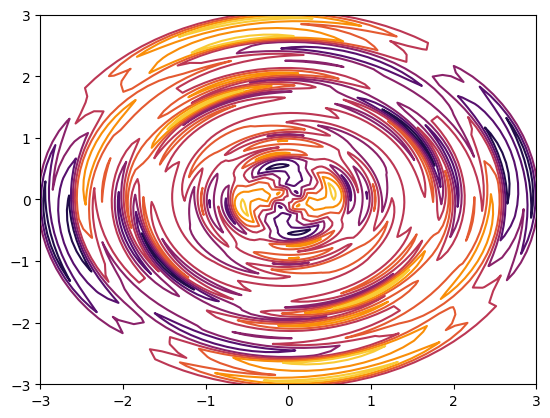

In [32]:
#Showing the whole distribution
plt.contour(x,y,z, cmap = 'inferno')
plt.xlim(-3,3)
plt.ylim(-3,3)

To analyize the distribution I need to create a `maxs` function that finds for each radial (bin), where the greatest amplitude of the bar is, which we can fit for later

In [33]:
def maxs(z,nbins):
    xmax = np.array([])
    ymax = np.array([])
    for i in np.arange(nbins):
        maxes = np.argsort(z[i])[-2:]
        xmax = np.append(xmax, x[i][maxes])
        ymax = np.append(ymax, y[i][maxes])
        a = np.sqrt(xmax**2+ymax**2) < 3
    return np.vstack(xmax[a]), np.vstack(ymax[a])

In [69]:
#Defining the maximum values for x and y
x1,y1=maxs(z,nbins)

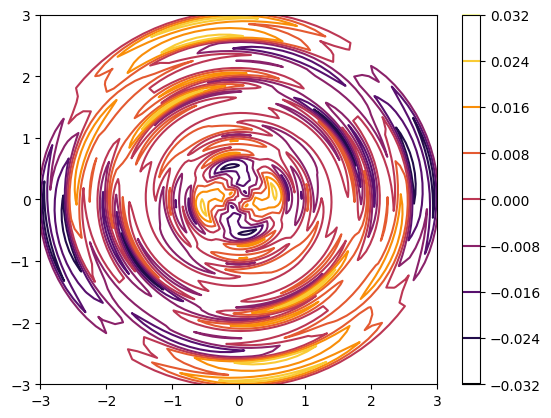

In [35]:
plt.contour(x,y,z, cmap = 'inferno')
#plt.scatter(x1,y1, c = 'k')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.colorbar()

This is a fairly unphysical result, as it assumes that these are the exact points where the bar is the strongest. Considering the fact bins were used, there must potential deviation caused by them. 

To solve this I'll employ a Monte Carlo Simulation sampling a smaller portion of the galaxy into a smaller fourier map to see which strongest points are really dominant (low standard deviation)

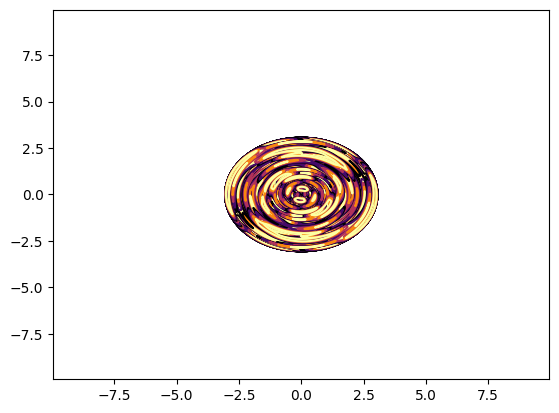

In [70]:
x_ = np.array([])
y_ = np.array([])
N = 60
for i in range(N):
    A = np.random.choice(range(len(sph['x'])), int(0.3*len(sph['x'])))
    sph_rand = sph[A]
    x, y, z = pynbody.plot.generic.fourier_map(sph_rand,mmin = 2, mmax =3, levels=[0.001,0.005,0.01,0.015,0.02], nbins=nbins, nmin=300, radius = 3, return_array = True, cmap = 'inferno')
    x_ = np.append(x_,maxs(z, nbins)[0])
    y_ = np.append(y_,maxs(z, nbins)[1])

In [71]:
#Finding the distribution
xstd = np.array([])
ystd = np.array([])
sigma = np.array([])

#Since the data is 2D, to find out what the actual "Standard Deviation", we need to calculate the determinant of the covariance matrix
for i in range(len(x1)):
    Dat=np.cov(np.array([x_[i::30],y_[i::30]]))
    xstd= np.append(xstd, abs(Dat[0,0]))
    ystd = np.append(ystd, abs(Dat[1,1]))
    sigma = np.append(sigma,abs(np.linalg.det((Dat))))

In [72]:
#Assuming the original data is the mean, we can say that the below is the standard error, and thus the error bars
xmean = np.sqrt(xstd/N).flatten()
ymean = np.sqrt(ystd/N).flatten()

#Sample weight for later, note that there is no sqrt
sigm1 = sigma/N

Now that everything is defined, lets get a look at the final product

(-3.0, 3.0)

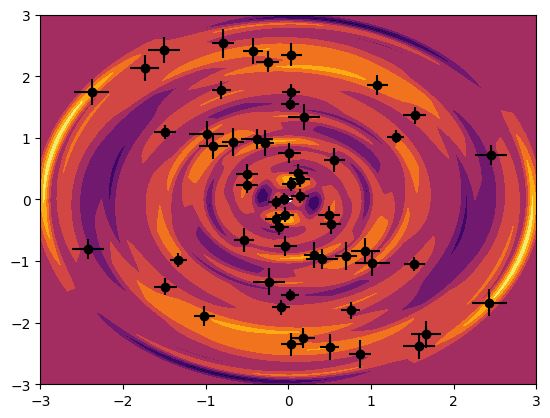

In [73]:
plt.contourf(x,y,z, cmap = 'inferno')
plt.errorbar(x1.flatten(),y1.flatten(),xerr=xmean,yerr=ymean,fmt = 'o', c = 'k')
plt.xlim(-3,3)
plt.ylim(-3,3)

Looks pretty good, note that the previosu code works just as well for the matter section of the galaxy as well, now onto the next step

___

## <font color='purple'> __Part 2__</font>
***Turning Bar into Bars***

Now we've successfully modelled 1 galaxies maximum points we need to do the same thing again for every other txt file (Or in this case every other one, since simulation takes a long time, and periodic data should not lose much information if taken every other point)

These were done in py files since it was better suited for long for loops, additionally to make it quicker I effectively multiprocessed the data by splitting it up into 16ths to all combine into 1 half

In [ ]:
%run Astrostats.py #[::16], [2::16]
%run Astrostats1copy.py#[4::16], [6::16]
%run Astrostats2.py #[8::16]], [10::16]
%run Astrostats2copy.py #[12::16], [14:16]

These files made 8 text files which I needed to organize into one larger txt file

In [31]:
#2,6,10,14
A1=np.loadtxt('MattMax_Y2Prime.txt', delimiter=' ')
A2=np.loadtxt('MattMax_Y6Prime.txt', delimiter=' ')
A3=np.loadtxt('MattMax_Y10Prime.txt', delimiter=' ')
A4=np.loadtxt('MattMax_Y14Prime.txt', delimiter=' ')
#0,4,8,12
B1 = np.loadtxt('MattMax_Y.txt', delimiter=' ')
B2 = np.loadtxt('MattMax_Y1.txt', delimiter=' ')
B3 = np.loadtxt('MattMax_Y2.txt', delimiter=' ')
B4 = np.loadtxt('MattMax_Y3.txt', delimiter=' ')

#Creating One Big Array
maxes=np.ones(60*(112+111)).reshape(223,60)

#Redefining the Components to make the final Data
maxes[::8]  = B1
maxes[1::8] = A1
maxes[2::8] = B2
maxes[3::8] = A2
maxes[4::8] = B3
maxes[5::8] = A3
maxes[6::8] = B4
maxes[7::8] = A4
np.savetxt('MattMaximumY.txt',maxes, delimiter = ' ')

This was done for all of the Dark Matter and Matter points, and stored for latter analysis

Note that this now means that the points will be plotted on their own and not in respect to the contours

___

## <font color='purple'> __Part 3__</font>
***Finding What Fits***

In [41]:
from sklearn.linear_model import RidgeCV #Regression Model that works better than Linear Regression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression #Regression Model that works better than Linear Regression
from matplotlib.animation import PillowWriter #Animator to see what the data looks like
import concurrent.futures #Multiprocessing module for faster for loops :D

In [116]:
#For Dark Matter
x1 = np.loadtxt('Maximum_X.txt', delimiter = ' ')
y1 = np.loadtxt('Maximum_Y.txt', delimiter = ' ')
sigm1 = np.loadtxt('Maximum_SIG.txt', delimiter = ' ')
Min = 10

In [98]:
#For Regular Matter
x1 = np.loadtxt('MattMaximum_X.txt', delimiter = ' ')
y1 = np.loadtxt('MattMaximum_Y.txt', delimiter = ' ')
sigm1 = np.loadtxt('MattMaximum_SIG.txt', delimiter = ' ')
Min = 10

In [75]:
#Models being generated
modelx = LinearRegression(fit_intercept=False)
modely = LinearRegression(fit_intercept = False)
modelWeakx = LinearRegression(fit_intercept=False)
modelWeaky = LinearRegression(fit_intercept=False)

In [117]:
#Models being generated
modelx = RidgeCV(fit_intercept=False)
modely = RidgeCV(fit_intercept = False)
modelWeakx = RidgeCV(fit_intercept=False)
modelWeaky = RidgeCV(fit_intercept=False)

Note that to find out the actual bar distribution, I need to find out where the primary and secondary bar start and end. To do that I made a pseudo prior (A set assumed radius) and a pseudo likelihood function (The maximum model score), to find the optimal radius where the primary bar ends for each timestep (Essentially a posterior distribution)

In [49]:
def OptimalR(i):
    Hs = np.arange(8)+ Min + 4
    score = []
    for H in Hs:
        
        modelx.fit(np.vstack(x1[i,Min:H]),np.vstack(y1[i,Min:H]), sample_weight=1/sigm1[i,Min:H])
        modely.fit(np.vstack(y1[i,Min:H]),np.vstack(x1[i,Min:H]), sample_weight=1/sigm1[i,Min:H])
        modelWeakx.fit(np.vstack(x1[i,H:]),np.vstack(y1[i,H:]),sample_weight=1/sigm1[i,H:])
        modelWeaky.fit(np.vstack(y1[i,H:]),np.vstack(x1[i,H:]),sample_weight=1/sigm1[i,H:])

        A = modelx.score(np.vstack(x1[i,Min:H]),np.vstack(y1[i,Min:H]),sample_weight=1/sigm1[i,Min:H])
        B = modely.score(np.vstack(y1[i,Min:H]),np.vstack(x1[i,Min:H]),sample_weight=1/sigm1[i,Min:H])
        C = modelWeakx.score(np.vstack(x1[i,H:]),np.vstack(y1[i,H:]),sample_weight=1/sigm1[i,H:])
        D = modelWeaky.score(np.vstack(y1[i,H:]),np.vstack(x1[i,H:]),sample_weight=1/sigm1[i,H:])

        #Picking the best sum
        score.append(max([A+C,A+D,B+C,B+D]))
    return Hs[np.argmax(score)]


Usec multiprocessing to make the function significantly faster

In [118]:
ranger = np.arange(223)
Hopt = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(OptimalR,ranger)
    for result in results:
        Hopt.append(result)
Hopt = np.array(Hopt)

Histogram to see what optimal radii look like

Text(0.5, 0, 'Bin')

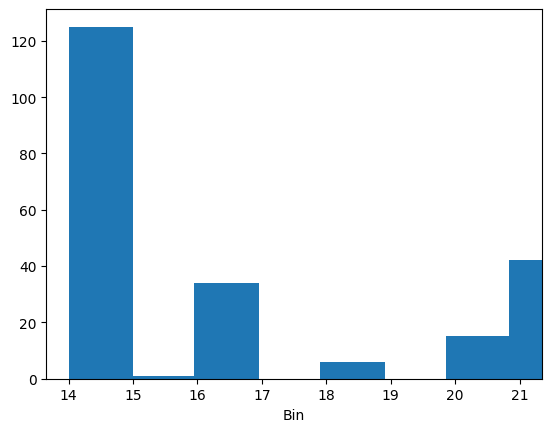

In [66]:
q1 = np.percentile(np.sort(Hopt), 25)
q3 = np.percentile(np.sort(Hopt), 75)
h = 2*(q3-q1)/(len(Hopt)**1/3)
plt.hist(Hopt, bins =int((19-12)/h), width = 1 )
plt.xlabel('Bin')

With the optimal radii found we can effectively fit the data for the angle

In [79]:
def Angle(i):
        Min = 10 #Incase not already defined
        x = np.vstack(x1[i])
        y = np.vstack(y1[i])
        sig = sigm1[i]


        modelx.fit(x[Min:Hopt[i]],y[Min:Hopt[i]], sample_weight=1/sig[Min:Hopt[i]])
        modely.fit(y[Min:Hopt[i]],x[Min:Hopt[i]], sample_weight=1/sig[Min:Hopt[i]])


        modelWeakx.fit(x[Hopt[i]:],y[Hopt[i]:], sample_weight=1/sig[Hopt[i]:])
        modelWeaky.fit(y[Hopt[i]:],x[Hopt[i]:], sample_weight=1/sig[Hopt[i]:])

        #Model Choice
        if np.argmax([modelx.score(x[Min:Hopt[i]], y[Min:Hopt[i]],sample_weight=1/sig[Min:Hopt[i]]),modely.score(y[Min:Hopt[i]],x[Min:Hopt[i]],sample_weight=1/sig[Min:Hopt[i]])]) == 0:
            m1 = modelx.coef_
        else:
            m1 = 1/modely.coef_ #Inverse to get the correct slope

        if np.argmax([modelWeakx.score(x[Hopt[i]:],y[Hopt[i]:],sample_weight=1/sig[Hopt[i]:]),modelWeaky.score(y[Hopt[i]:],x[Hopt[i]:],sample_weight=1/sig[Hopt[i]:])]) == 0:
            m2 = modelWeakx.coef_
        else:
            m2 = 1/modelWeaky.coef_
        return np.arctan(m1), np.arctan(m2)

In [119]:
ranger = np.arange(223)
phi = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(Angle,ranger)
    for result in results:
        phi.append(result)
phi = np.array(phi).reshape(223,2)

___

## <font color='purple'> __Part 4__</font>
***Over Time***

In [102]:
from astroML.time_series import lomb_scargle_BIC #Important for fitting and model strength
from astropy.timeseries import LombScargle

Generating and fitting the data, used 10% error since it felt reasonable considering any issue with bins

In [120]:
a = int(0) 
period = 10 ** np.linspace(0.1, 3.1, 10000)
omega = 1. / period
LS = LombScargle(np.arange(223), phi[:,a], abs(phi[:,a]*0.1)) #Setting up Model
PS = LS.power(omega)

0.9919904451903883


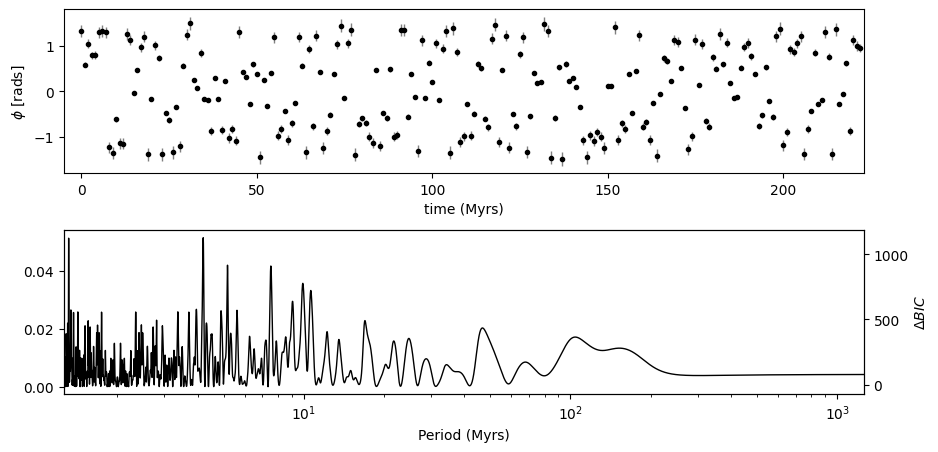

In [126]:
#Final plotting part, creates the two part plot, essentially same as in lecture, just with differnet data
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=0.1, right=0.9, hspace=0.35)
ax = plt.subplot(211)
ax.errorbar(np.arange(223), phi[:,a], abs(phi[:,a]*0.1), fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (Myrs)')
ax.set_ylabel('$\phi$ [rads]')
ax.set_xlim(-5, 223)

ax1 = plt.subplot(212, xscale = 'log' )
ax1.set_xlabel('Period (Myrs)')
ax1.set_xlim(period[0], period[-1])
ax1.plot(period, PS, '-', 
         c='black', lw=1, zorder=1)

ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), phi[:,1], abs(phi[:,1]*0.1))))
ax2.set_ylabel(r'$\Delta BIC$')


#Final Bits of Analysis
best_freq = omega[np.argmax(PS)]
best_freq = omega[np.argmax(PS)]
print(LS.false_alarm_probability(PS.max()))

Final Fitting to see what the data looks like

Text(0, 0.5, '$\\phi$')

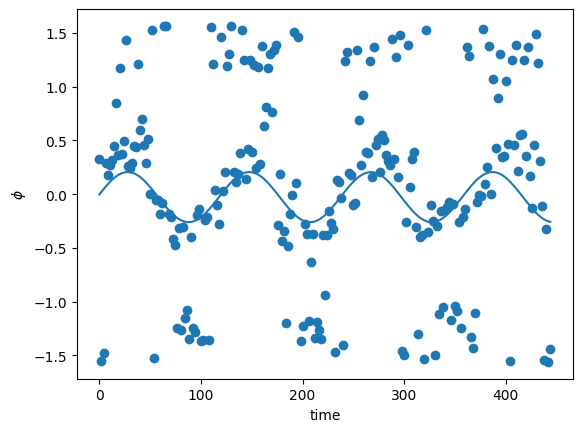

In [127]:
plt.scatter(np.arange(223)*2,phi[:,1])
plt.plot(np.arange(223)*2,fit)
plt.xlabel('time')
plt.ylabel('$\phi$')

Interesting fit, there is ultimately something quite significant in these results, as both functions are periodic but in strangely different ways, there is likely some relationship between the bars that evolves over time, but since the bar itself is weak the dark matter bar is not very signficantly influenced or particularly strong

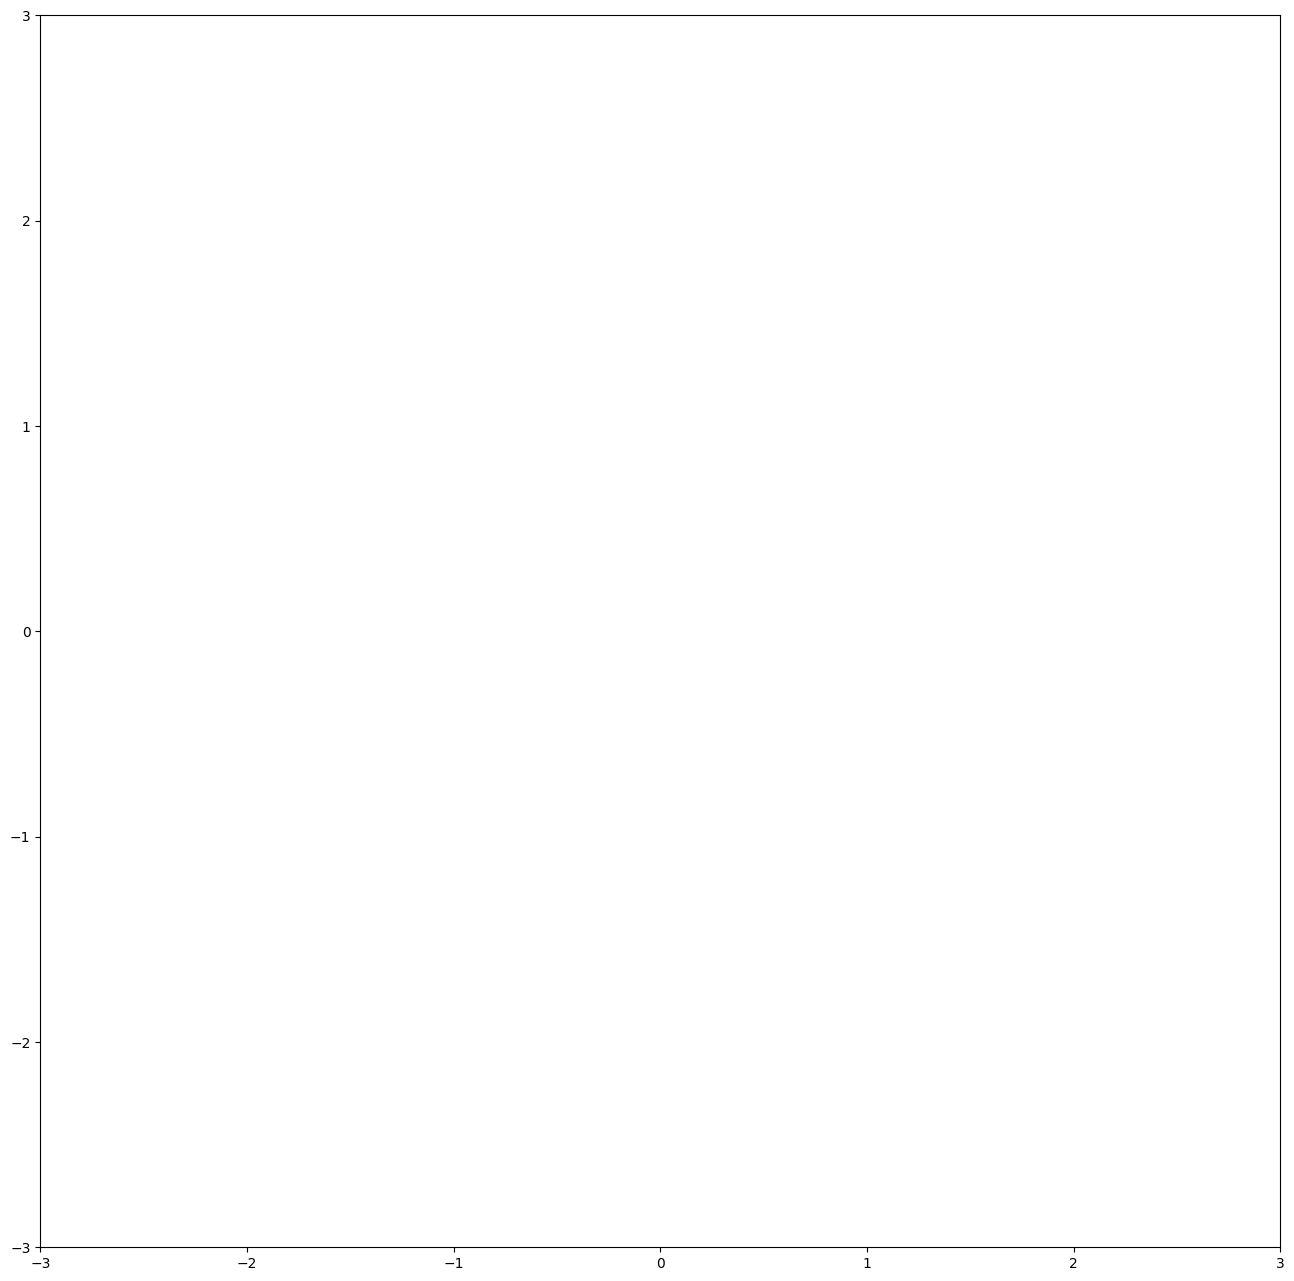

In [371]:
fig, ax = plt.subplots(figsize = (16,16))
plt.xlim(-3,3)
plt.ylim(-3,3)

metadata=dict(title='Movie', artist ='codinglikemad')
writer = PillowWriter(fps=7, metadata=metadata)

Makes Movies to help get an idea on next moves to make

In [373]:
with writer.saving(fig,"Astro1.gif",100):
    for i in tqdm(np.arange(223)):
        ax.axes.set_xlim(-3,3)
        ax.axes.set_ylim(-3,3)
        x = np.vstack(x1[i])
        y = np.vstack(y1[i])
        sig = sigm1[i]
        ax.scatter(x1[i],y1[i],c = 'k')


        modelx.fit(x[Min:Hopt[i]],y[Min:Hopt[i]], sample_weight=1/sig[Min:Hopt[i]])
        modely.fit(y[Min:Hopt[i]],x[Min:Hopt[i]], sample_weight=1/sig[Min:Hopt[i]])


        modelWeakx.fit(x[Hopt[i]:],y[Hopt[i]:], sample_weight=1/sig[Hopt[i]:])
        modelWeaky.fit(y[Hopt[i]:],x[Hopt[i]:], sample_weight=1/sig[Hopt[i]:])


        if np.argmax([modelx.score(x[Min:Hopt[i]], y[Min:Hopt[i]],sample_weight=1/sig[Min:Hopt[i]]),modely.score(y[Min:Hopt[i]],x[Min:Hopt[i]],sample_weight=1/sig[Min:Hopt[i]])]) == 0:
            ax.plot(x[Min:Hopt[i]], modelx.predict(x[Min:Hopt[i]]), linewidth = 5, c = 'r', label = i)
        else:
            ax.plot(modely.predict(y[Min:Hopt[i]]),y[Min:Hopt[i]], linewidth = 5, c = 'r', label = i)


        if np.argmax([modelWeakx.score(x[Hopt[i]:],y[Hopt[i]:],sample_weight=1/sig[Hopt[i]:]),modelWeaky.score(y[Hopt[i]:],x[Hopt[i]:],sample_weight=1/sig[Hopt[i]:])]) == 0:
            ax.plot(x[Hopt[i]:], modelWeakx.predict(x[Hopt[i]:]), linewidth = 5, c = 'purple', alpha = 0.6)
        else:
            ax.plot(modelWeaky.predict(y[Hopt[i]:]), y[Hopt[i]:], linewidth = 5, c = 'purple', alpha = 0.6)
        writer.grab_frame()
        ax.legend()
        ax.cla()
        i += 1

100%|██████████| 223/223 [00:20<00:00, 11.12it/s]


That is my entire project for Astrostats, thank you for the semester :D